In [54]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
import os
import random
import shutil

In [117]:
train_dir = 'reorganized'

limited_dir = 'train_limited'
os.makedirs(limited_dir, exist_ok=True)

In [127]:
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if os.path.isdir(class_path):
    
        all_images = [os.path.join(class_path, fname) for fname in os.listdir(class_path)]
        
        selected_images = random.sample(all_images, 115)
        
        class_dest = os.path.join(limited_dir, class_name)
        os.makedirs(class_dest, exist_ok=True)
        
        for image in selected_images:
            shutil.copy(image, class_dest)

In [56]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [120]:
train_limited_dir = 'train_limited'
train_set_dir = 'train_set'
valid_set_dir = 'valid_set'

os.makedirs(train_set_dir, exist_ok=True)
os.makedirs(valid_set_dir, exist_ok=True)

In [57]:
from sklearn.model_selection import train_test_split
import numpy as np

In [128]:
for class_name in os.listdir(train_limited_dir):
    class_dir = os.path.join(train_limited_dir, class_name)
    if os.path.isdir(class_dir):
        images = [os.path.join(class_dir, image) for image in os.listdir(class_dir)]
        

        train_images, valid_images = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_set_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(valid_set_dir, class_name), exist_ok=True)
        
        for image in train_images:
            shutil.move(image, os.path.join(train_set_dir, class_name, os.path.basename(image)))
        
        for image in valid_images:
            shutil.move(image, os.path.join(valid_set_dir, class_name, os.path.basename(image)))

print("Dataset has been split and saved successfully.")

Dataset has been split and saved successfully.


In [134]:
train_set_dir = 'train_set'
train_augmentation_dir = 'train_augmented'

os.makedirs(train_augmentation_dir, exist_ok=True)

In [201]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest')

In [202]:
for class_name in os.listdir(train_set_dir):
    class_dir = os.path.join(train_set_dir, class_name)
    
    if os.path.isdir(class_dir):
        augmented_class_dir = os.path.join(train_augmentation_dir, class_name)
        os.makedirs(augmented_class_dir, exist_ok=True)
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                img = image.load_img(img_path)
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0) 

                i = 0
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_class_dir, save_prefix=img_name.split('.')[0], save_format='jpeg'):
                    i += 1
                    if i > 3: 
                        break

print("Data augmentation applied successfully, and augmented images saved.")

Data augmentation applied successfully, and augmented images saved.


##Image Processing

In [5]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'train_dir',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 38569 files belonging to 7 classes.


In [44]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'val_dir',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 938 files belonging to 7 classes.


In [46]:
def Normalizer(image,label):
    image = tf.cast(image/255.,tf.float32)
    return image, label
training_set, validation_set = training_set.map(Normalizer), validation_set.map(Normalizer)


# Model Build

In [8]:
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

In [9]:
model = Sequential()

In [10]:
model.add(Conv2D(16, kernel_size=(3, 3), activation = 'relu', input_shape=[96,96,3], padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

In [11]:
model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [12]:
model.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [13]:
model.add(Flatten())

In [14]:
model.add(Dense(units=1024,activation='relu'))
model.add(BatchNormalization())
#model.add(Dense(units=32,activation='relu'))

In [15]:
model.add(Dropout(0.5))

In [16]:
model.add(Dense(units=7,activation='softmax'))

In [ ]:
'''initial_lr = 0.001
final_lr = 0.00001
decay_step = 32 * 20
decay = (final_lr/initial_lr)**(1/decay_step)
learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate = initial_lr,
                decay_steps = decay_step,
                decay_rate = 0.96,
                staircase = False)'''

In [17]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
               monitor='val_loss',
               factor = 0.25,
               patience = 3,
               min_lr = 0.00001)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

# Train Model

In [20]:
training_history = model.fit(x=training_set, validation_data=validation_set, epochs=10, batch_size = 32, callbacks=[reduce_lr])

Epoch 1/10
1206/1206 [==============================] - 367s 303ms/step - loss: 1.4293 - accuracy: 0.4851 - val_loss: 0.6897 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 2/10
1206/1206 [==============================] - 379s 314ms/step - loss: 1.0693 - accuracy: 0.5944 - val_loss: 1.0093 - val_accuracy: 0.6759 - lr: 0.0010
Epoch 3/10
1206/1206 [==============================] - 373s 310ms/step - loss: 0.9496 - accuracy: 0.6401 - val_loss: 1.5194 - val_accuracy: 0.4414 - lr: 0.0010
Epoch 4/10
1206/1206 [==============================] - 378s 313ms/step - loss: 0.8608 - accuracy: 0.6731 - val_loss: 0.9166 - val_accuracy: 0.7036 - lr: 0.0010
Epoch 5/10
1206/1206 [==============================] - 379s 314ms/step - loss: 0.6764 - accuracy: 0.7419 - val_loss: 0.3560 - val_accuracy: 0.8699 - lr: 2.5000e-04
Epoch 6/10
1206/1206 [==============================] - 384s 318ms/step - loss: 0.6102 - accuracy: 0.7658 - val_loss: 0.3689 - val_accuracy: 0.8678 - lr: 2.5000e-04
Epoch 7/10
1206/1206 [====

In [23]:
training_history = model.fit(x=training_set, validation_data=validation_set, epochs=10, batch_size = 32, callbacks=[reduce_lr])

Epoch 1/10
1206/1206 [==============================] - 372s 308ms/step - loss: 0.4114 - accuracy: 0.8453 - val_loss: 0.5033 - val_accuracy: 0.8422 - lr: 2.5000e-04
Epoch 2/10
1206/1206 [==============================] - 386s 320ms/step - loss: 0.3767 - accuracy: 0.8577 - val_loss: 0.6797 - val_accuracy: 0.8145 - lr: 2.5000e-04
Epoch 3/10
1206/1206 [==============================] - 379s 314ms/step - loss: 0.3596 - accuracy: 0.8653 - val_loss: 0.4538 - val_accuracy: 0.8614 - lr: 2.5000e-04
Epoch 4/10
1206/1206 [==============================] - 386s 320ms/step - loss: 0.3279 - accuracy: 0.8768 - val_loss: 0.4247 - val_accuracy: 0.8646 - lr: 2.5000e-04
Epoch 5/10
1206/1206 [==============================] - 393s 326ms/step - loss: 0.3126 - accuracy: 0.8831 - val_loss: 0.4659 - val_accuracy: 0.8614 - lr: 2.5000e-04
Epoch 6/10
1206/1206 [==============================] - 390s 323ms/step - loss: 0.2866 - accuracy: 0.8922 - val_loss: 0.5318 - val_accuracy: 0.8454 - lr: 2.5000e-04
Epoch 7/10

In [26]:
training_history = model.fit(x=training_set, validation_data=validation_set, epochs=10, batch_size = 32, callbacks=[reduce_lr])

Epoch 1/10
1206/1206 [==============================] - 369s 306ms/step - loss: 0.1892 - accuracy: 0.9317 - val_loss: 0.3976 - val_accuracy: 0.8795 - lr: 6.2500e-05
Epoch 2/10
1206/1206 [==============================] - 394s 326ms/step - loss: 0.1802 - accuracy: 0.9347 - val_loss: 0.4278 - val_accuracy: 0.8849 - lr: 6.2500e-05
Epoch 3/10
1206/1206 [==============================] - 399s 331ms/step - loss: 0.1731 - accuracy: 0.9377 - val_loss: 0.3977 - val_accuracy: 0.8849 - lr: 6.2500e-05
Epoch 4/10
1206/1206 [==============================] - 410s 340ms/step - loss: 0.1701 - accuracy: 0.9377 - val_loss: 0.4432 - val_accuracy: 0.8838 - lr: 6.2500e-05
Epoch 5/10
1206/1206 [==============================] - 403s 334ms/step - loss: 0.1545 - accuracy: 0.9441 - val_loss: 0.4146 - val_accuracy: 0.8849 - lr: 1.5625e-05
Epoch 6/10
1206/1206 [==============================] - 401s 332ms/step - loss: 0.1522 - accuracy: 0.9451 - val_loss: 0.4089 - val_accuracy: 0.8849 - lr: 1.5625e-05
Epoch 7/10

In [ ]:
import json
hist = training_history.history
convert = {key: [float(val) for val in values] for key,values in hist.items()}
with open('trainig_history3', 'w') as f:
    json.dump(convert,f)

In [28]:
model.save("train_model2.keras")

In [6]:
model = tf.keras.models.load_model('train_model1.keras')

# Load History

In [36]:
with open('trainig_history1', 'r') as f:
    history1 = json.load(f)

In [31]:
train_acc = model.evaluate(training_set)

1206/1206 [==============================] - 68s 57ms/step - loss: 0.0339 - accuracy: 0.9925


In [32]:
valid_acc = model.evaluate(validation_set)

30/30 [==============================] - 2s 55ms/step - loss: 0.4104 - accuracy: 0.8838


In [33]:
print(train_acc, valid_acc)

[0.03391946479678154, 0.9925069212913513] [0.4104405343532562, 0.8837953209877014]


# Plot Graph

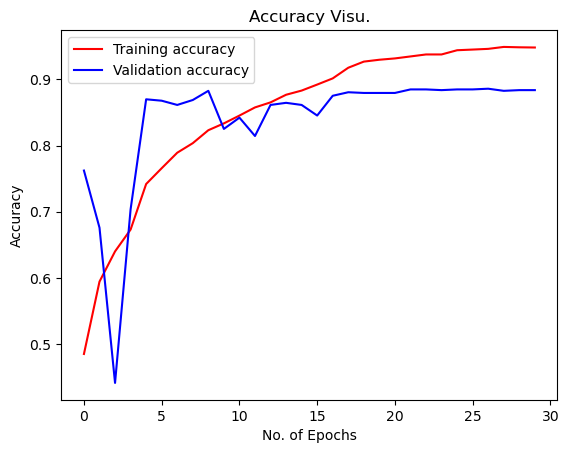

In [40]:
epochs = range(len(history1["loss"]))
plt.plot(epochs,history1['accuracy'],color='red',label='Training accuracy')
plt.plot(epochs,history1['val_accuracy'],color='blue',label='Validation accuracy')
plt.legend()
plt.title("Accuracy Visu.")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.show()

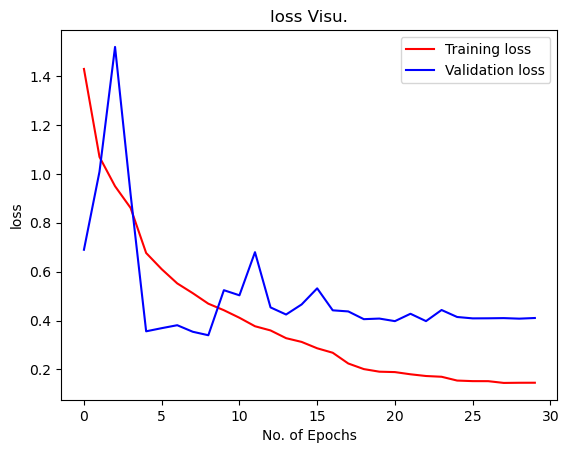

In [41]:
epochs = range(len(history1["loss"]))
plt.plot(epochs,history1['loss'],color='red',label='Training loss')
plt.plot(epochs,history1['val_loss'],color='blue',label='Validation loss')
plt.legend()
plt.title("loss Visu.")
plt.xlabel("No. of Epochs")
plt.ylabel("loss")
plt.show()